Copyright © 2024, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Creating a Complete Model Card for a Python Model using Python-sasctl
This notebook walks through the steps for building a complete model card for a Python model. 

***
##  Table of Contents
1. [Introduction](#Introduction)
1. [Gather Resources](#Gather-Resources)
1. [Explore and Prepare Data](#Explore-and-Prepare-Data)
1. [Train and Assess Model](#Train-and-Assess-Model)
1. [Prepare Model Files and Register into SAS Model Manager](#Prepare-Model-Files-and-Register-into-SAS-Model-Manager)
1. [Conclusion](#Conclusion)

***
## Introduction
Model cards were introduced with the SAS Viya 2024.07 release and act as a nutrition label for AI models. The model cards in SAS Viya feature easy-to-understand visuals and actionable takeaways. When designing the model card, SAS made sure it contained useful and digestible information for a variety of stakeholders and would become a natural extension of the model’s lifecycle. As you develop and manage models within SAS Viya, the model card starts to populate. Complete model cards can be built for Python models using the python-sasctl package and tools on SAS Viya. This notebook will review the steps performed via Python-sasctl. 

*** 
## Gather Resources 
First, we need to import the packages we will use. Make sure you are using the latest version of python-sasctl!

In [1]:
# Standard Library
from pathlib import Path
import warnings
import os
import json

# Third Party
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import getpass

# Application Specific
import sasctl.pzmm as pzmm
from sasctl import Session
from sasctl.services import model_repository as mr

# Global Package Options
pd.options.mode.chained_assignment = None  # default="warn"
plt.rc("font", size=14)

# Ignore warnings from pandas about SWAT using a feature that will be depreciated soon
warnings.simplefilter(action="ignore", category=FutureWarning)

Next, we need to import our data. We are using the [Adult dataset](https://archive.ics.uci.edu/dataset/2/adult) from the UC Irvine Machine Learning Repository. Before bringing the data into this notebook, I removed the fnlwgt and education-num columns and created a binary indicator for the income variable.

In [2]:
adult = pd.read_csv("data/adult.csv", sep= ",")

print("Shape of data:", adult.shape)

Shape of data: (32561, 11)


***
## Explore and Prepare Data
Before moving further, let's explore the dataset. We'll start by looking at a sample of the data. 

In [3]:
adult.head()

,Age,WorkClass,Education,MartialStatus,Occupation,Relationship,Race,Sex,HoursPerWeek,NativeCountry,GE50K
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0


Next, we'll look at missing values. 

In [4]:
adult.isnull().sum()

Age                 0
WorkClass        1836
Education           0
MartialStatus       0
Occupation       1843
Relationship        0
Race                0
Sex                 0
HoursPerWeek        0
NativeCountry     583
GE50K               0
dtype: int64

And at the distribution of the continuous variables.   

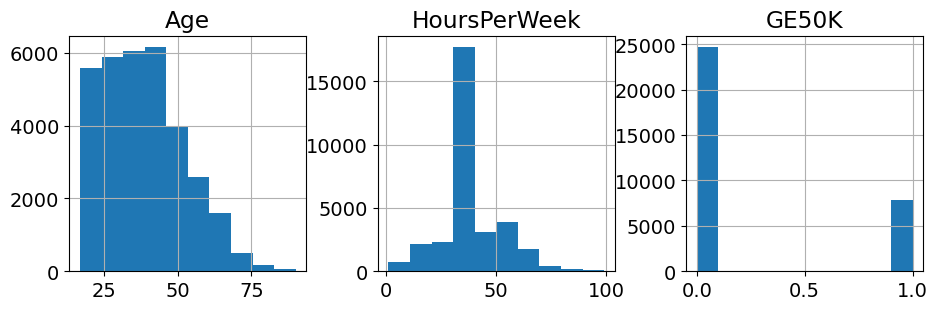

In [6]:
adult.hist(figsize=(15,15), layout=(4, 4));

Let's also look at the unique values and value counts for the categorical variables. 

In [5]:
print("Unique Values: ")
print(adult[adult.select_dtypes(include=['object']).columns].nunique())
print("--------------------------------")
print("Value Counts: ")
for i in adult.select_dtypes(include=['object']).columns:
     print(adult[i].value_counts())
     print("--------------------------------")

Unique Values: 
WorkClass         8
Education        16
MartialStatus     7
Occupation       14
Relationship      6
Race              5
Sex               2
NativeCountry    41
dtype: int64
--------------------------------
Value Counts: 
WorkClass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
--------------------------------
Education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64
--------------------------------
MartialStatus
Married-civ-spouse       14976
Never-married       

There is a lot of unique values for the categorical variables. Let's combine similar categorical values and one-hot-encode our categorical variables. 

In [7]:
df = adult.copy()
df = df.dropna().reset_index()
cat_vals = df[["WorkClass", "Education", "MartialStatus", "Relationship", "Race", "Sex"]]
df = pd.get_dummies(df, columns=["WorkClass", "Education", "MartialStatus", "Relationship", "Race", "Sex"])
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('-', '_')
df = df.drop(['Sex_Male'], axis=1)
df = pd.concat([df, cat_vals], axis=1).drop('index', axis=1)


The data is looking better, but the martial status, education and work class statuses are a bit too granular. Lets combine some of them to make the job easier for our model.

In [8]:
df["Education_Some_HS"] = df["Education_9th"] | df["Education_10th"] | df["Education_11th"] | df["Education_12th"]
df["Education_Assoc"] = df["Education_Assoc_voc"] | df["Education_Assoc_acdm"]
df["Education_Adv_Degree"] = df["Education_Masters"] | df["Education_Prof_school"] | df["Education_Doctorate"]
df["Education_No_HS"] = df["Education_Preschool"] | df["Education_1st_4th"] | df["Education_5th_6th"] | df["Education_7th_8th"]

df["WorkClass_Self"] = df["WorkClass_Self_emp_inc"] | df["WorkClass_Self_emp_not_inc"]
df["WorkClass_Gov"] = df["WorkClass_Federal_gov"] | df["WorkClass_Local_gov"] | df["WorkClass_State_gov"]
df["WorkClass_Other"] = df["WorkClass_Without_pay"] # df["WorkClass_Never_worked"] is fully dropped when all NA values removed

df["MartialStatus_Other"] = df["MartialStatus_Married_spouse_absent"] | df["MartialStatus_Married_AF_spouse"]

df.columns

Index(['Age', 'Occupation', 'HoursPerWeek', 'NativeCountry', 'GE50K',
       'WorkClass_Federal_gov', 'WorkClass_Local_gov', 'WorkClass_Private',
       'WorkClass_Self_emp_inc', 'WorkClass_Self_emp_not_inc',
       'WorkClass_State_gov', 'WorkClass_Without_pay', 'Education_10th',
       'Education_11th', 'Education_12th', 'Education_1st_4th',
       'Education_5th_6th', 'Education_7th_8th', 'Education_9th',
       'Education_Assoc_acdm', 'Education_Assoc_voc', 'Education_Bachelors',
       'Education_Doctorate', 'Education_HS_grad', 'Education_Masters',
       'Education_Preschool', 'Education_Prof_school',
       'Education_Some_college', 'MartialStatus_Divorced',
       'MartialStatus_Married_AF_spouse', 'MartialStatus_Married_civ_spouse',
       'MartialStatus_Married_spouse_absent', 'MartialStatus_Never_married',
       'MartialStatus_Separated', 'MartialStatus_Widowed',
       'Relationship_Husband', 'Relationship_Not_in_family',
       'Relationship_Other_relative', 'Relationshi

If we want the automatically generated score code to leaverage these steps when scoring new data, we can put them in a preprocessing function and pass them into our import_model function call. 

In [ ]:
def preprocess_function(df):
    cat_vals = df[["WorkClass", "Education", "MartialStatus", "Relationship", "Race", "Sex"]]
    df = pd.get_dummies(df, columns=["WorkClass", "Education", "MartialStatus", "Relationship", "Race", "Sex"])
    df.columns = df.columns.str.replace(' ', '')
    df.columns = df.columns.str.replace('-', '_')
    df = df.drop(['Sex_Male'], axis=1)
    if 'index' in df.columns or 'index' in cat_vals.columns:
        df = pd.concat([df, cat_vals], axis=1).drop('index', axis=1)
    # For the model to score correctly, all OHE columns must exist
    input_cols = [
        "Education_9th", "Education_10th", "Education_11th", "Education_12th", "Education_Assoc_voc", "Education_Assoc_acdm", "Education_Masters", "Education_Prof_school",
        "Education_Doctorate", "Education_Preschool", "Education_1st_4th", "Education_5th_6th", "Education_7th_8th", "WorkClass_Self_emp_inc", "WorkClass_Self_emp_not_inc",
        "WorkClass_Federal_gov", "WorkClass_Local_gov", "WorkClass_State_gov", "WorkClass_Without_pay", "WorkClass_Never_worked", "MartialStatus_Married_spouse_absent",
        "MartialStatus_Married_AF_spouse", 'MartialStatus_Married_civ_spouse', 'MartialStatus_Never_married', 'MartialStatus_Divorced', 'MartialStatus_Separated', 
        'MartialStatus_Widowed', 'Race_White', 'Race_Black', 'Race_Asian_Pac_Islander', 'Race_Amer_Indian_Eskimo', 'Race_Other', 'Relationship_Husband', 
        'Relationship_Not_in_family', 'Relationship_Own_child', 'Relationship_Unmarried', 'Relationship_Wife', 'Relationship_Other_relative', 'WorkClass_Private',
        'Education_Bachelors', 'Education_Some_college', 'Education_HS_grad'
    ]
    # OHE columns must be removed after data combination
    predictor_columns = ['Age', 'HoursPerWeek', 'WorkClass_Private', 'WorkClass_Self', 'WorkClass_Gov', 
       'WorkClass_Other', 'Education_HS_grad', 'Education_Some_HS', 'Education_Assoc', 'Education_Some_college',
       'Education_Bachelors', 'Education_Adv_Degree', 'Education_No_HS', 'MartialStatus_Married_civ_spouse',
       'MartialStatus_Never_married', 'MartialStatus_Divorced', 'MartialStatus_Separated', 'MartialStatus_Widowed',
       'MartialStatus_Other', 'Relationship_Husband', 'Relationship_Not_in_family', 'Relationship_Own_child', 'Relationship_Unmarried',
       'Relationship_Wife', 'Relationship_Other_relative', 'Race_White', 'Race_Black', 'Race_Asian_Pac_Islander',
       'Race_Amer_Indian_Eskimo', 'Race_Other', 'Sex_Female']

    for col in input_cols:
        if col not in df.columns:
            df[col] = 0
    

    df["Education_Some_HS"] = df["Education_9th"] | df["Education_10th"] | df["Education_11th"] | df["Education_12th"]
    df["Education_Assoc"] = df["Education_Assoc_voc"] | df["Education_Assoc_acdm"]
    df["Education_Adv_Degree"] = df["Education_Masters"] | df["Education_Prof_school"] | df["Education_Doctorate"]
    df["Education_No_HS"] = df["Education_Preschool"] | df["Education_1st_4th"] | df["Education_5th_6th"] | df["Education_7th_8th"]

    df["WorkClass_Self"] = df["WorkClass_Self_emp_inc"] | df["WorkClass_Self_emp_not_inc"]
    df["WorkClass_Gov"] = df["WorkClass_Federal_gov"] | df["WorkClass_Local_gov"] | df["WorkClass_State_gov"]
    df["WorkClass_Other"] = df["WorkClass_Without_pay"] | df["WorkClass_Never_worked"]

    df["MartialStatus_Other"] = df["MartialStatus_Married_spouse_absent"] | df["MartialStatus_Married_AF_spouse"]

    df = df[predictor_columns]

    return df

Finally, let's create a training, testing, and validation set. 

In [9]:
original_columns = ['Age', 'WorkClass', 'Education', 'MartialStatus', 
       'Relationship', 'Race', 'Sex', 'HoursPerWeek', 'GE50K']

original_inputs = ['Age', 'WorkClass', 'Education', 'MartialStatus', 
       'Relationship', 'Race', 'Sex', 'HoursPerWeek']

predictor_columns = ['Age', 'HoursPerWeek', 'WorkClass_Private', 'WorkClass_Self', 'WorkClass_Gov', 
       'WorkClass_Other', 'Education_HS_grad', 'Education_Some_HS', 'Education_Assoc', 'Education_Some_college',
       'Education_Bachelors', 'Education_Adv_Degree', 'Education_No_HS', 'MartialStatus_Married_civ_spouse',
       'MartialStatus_Never_married', 'MartialStatus_Divorced', 'MartialStatus_Separated', 'MartialStatus_Widowed',
       'MartialStatus_Other', 'Relationship_Husband', 'Relationship_Not_in_family', 'Relationship_Own_child', 'Relationship_Unmarried',
       'Relationship_Wife', 'Relationship_Other_relative', 'Race_White', 'Race_Black', 'Race_Asian_Pac_Islander',
       'Race_Amer_Indian_Eskimo', 'Race_Other', 'Sex_Female']

target_column = "GE50K"

x = df[list(dict.fromkeys(original_columns + predictor_columns))]

y = df[target_column]

x_train_full, x_test_full, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)
x_train_full, x_val_full, y_train, y_val = train_test_split(x_train_full, y_train, test_size=.2, random_state=42)

x_train = x_train_full[predictor_columns]
x_test = x_test_full[predictor_columns]
x_val = x_val_full[predictor_columns]

***
## Train and Assess Model
Our data is ready for modeling, so let's train a simple decision tree model!

In [10]:
dtc = DecisionTreeClassifier(max_depth=7, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=500)
dtc = dtc.fit(x_train, y_train)

Great, let's look at how well our model performed. 

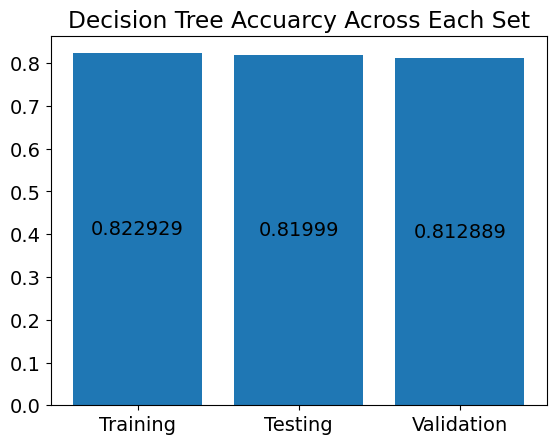

In [11]:
y_axis =np.array(["Training", "Testing", "Validation"])
x_axis = np.array([(dtc.score(x_train, y_train)), (dtc.score(x_test, y_test)), (dtc.score(x_val, y_val))])

fig, ax = plt.subplots()
p = ax.bar(x = y_axis, height = x_axis)
ax.bar_label(p, label_type='center')
ax.set_title('Decision Tree Accuarcy Across Each Set')
plt.show()



## Prepare Model Files and Register into SAS Model Manager
Since I'm happy with my model, let's add it into SAS Model Manager with all the metadata it needs to build a Model Card. Once the model is within SAS Model Manager, I can build a complete card by updating the model usage properties, specifying thresholds for Key Performance Indicators (KPIs), and running performance monitoring reports in SAS Model Manager.
But from our Python development environment, I need to do the following:
1. Update the variables in the block below to make sure everything matches my current use case. 
1. Connect to SAS Viya. 
1. Create a folder for my output files. 
1. Pickle my model.  
1. Write the input variables to a file. 
1. Write the output variables to a file. 
1. Write the model properties to a file. 
1. Write the file metadata.
1. Score training, testing, and validation data. 
1. Write model performance statistics to a file. 
1. Assess model bias and fairness (if a potentially sensitive variable is available for assessment). 
1. Generate the last few model card files. 
1. Generate requirements file. 
1. Import model to SAS Model Manager and automatically generate the score code. 
1. Open the model in SAS Model Manager and begin managing the model lifecycle there. 

So first, be sure that the variables in the block below match your use case.

In [12]:
# Step 1: Update variables below to fit your needs
output_directory = 'outputs'
model_prefix = 'dtc'
model_object = dtc
target= "GE50K"
algorithm = "Decision Tree"
description = "SKLearn Decision Tree Model"
assess_bias_var = 'Sex'
cat_columns = ['WorkClass', 'Education', 'MartialStatus', 'Relationship', 'Race', 'Sex']
interval_columns = ['Age', 'HoursPerWeek']
mm_project = "Salary Classification"

Next, let's build our connection to SAS Viya. 

In [13]:
# Step 2: Connect to SAS Viya
username = input("Username: ")
password = getpass.getpass("Password: ")
host = input("Viya Environment URL: ")
sess = Session(host, username, password, protocol="http") # For TLS-enabled servers, change protocol value to "https"
conn = sess.as_swat() # Connect to SWAT through the sasctl authenticated connection


Now, let's build our metadata files. 

In [ ]:
# Step 3: Create folder for output files. 
output_path = Path.cwd() / output_directory / model_prefix
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Step 4: Pickle model
pzmm.PickleModel.pickle_trained_model(
        model_prefix=model_prefix,
        trained_model=model_object,
        pickle_path=output_path)

# Step 5: Write input variables file
pzmm.JSONFiles.write_var_json(input_data=x[original_inputs], is_input=True, json_path=output_path)

# Step 6: Write output variables file
output_var = pd.DataFrame(columns=["EM_CLASSIFICATION", "EM_EVENTPROBABILITY"], data=[["A", 0.5]])
pzmm.JSONFiles.write_var_json(output_var, is_input=False, json_path=output_path)

# Step 7: Write model properties files
pzmm.JSONFiles.write_model_properties_json(
    model_name=model_prefix, 
    target_variable=target, 
    target_values=["1", "0"], 
    json_path=output_path, 
    model_desc=description,
    model_algorithm=algorithm,
    modeler=username,
)

# Step 8: Write file metadata file
pzmm.JSONFiles.write_file_metadata_json(model_prefix=model_prefix, json_path=output_path)


Next, let's score our training, testing, and validation data sets using our model. 

In [15]:
# Step 9: Score training, testing, and validation data 
t1 = 'P_' + target + '1'
t0 = 'P_' + target + '0'
ti = 'I_'+ target

train_scored = pd.DataFrame({t1: model_object.predict_proba(x_train)[:,1], 
                                 t0: model_object.predict_proba(x_train)[:,0], 
                                 ti: model_object.predict(x_train), 
                                 target: y_train, 
                                 assess_bias_var: x_train_full[assess_bias_var], 
                                 'Split': 'Train'})

test_scored = pd.DataFrame({t1: model_object.predict_proba(x_test)[:,1], 
                                 t0: model_object.predict_proba(x_test)[:,0], 
                                 ti: model_object.predict(x_test),
                                 target: y_test, 
                                 assess_bias_var: x_test_full[assess_bias_var], 
                                 'Split': 'Testing'})

val_scored = pd.DataFrame({t1: model_object.predict_proba(x_val)[:,1], 
                                 t0: model_object.predict_proba(x_val)[:,0], 
                                 ti: model_object.predict(x_val),
                                 target: y_val, 
                                 assess_bias_var: x_val_full[assess_bias_var], 
                                 'Split': 'Validation'})

scored = pd.concat([train_scored, test_scored, val_scored])


And write the performance metrics to a file so we can preserve how our model was performing at the time of training. 

In [ ]:
# Step 10: Write model statistics files
pzmm.JSONFiles.calculate_model_statistics(
        target_value=1,
        train_data=train_scored[[target, ti, t1]], 
        test_data=test_scored[[target, ti, t1]],
        validate_data=test_scored[[target, ti, t1]],
        json_path=output_path
    )

Since we also have variables that contain information about protected classes, we can look at bias and fairness information to determine if our model is scoring differently across these classes or if our model performs better on one class over the other. When generating these values, I recommend using a variable where the group values are in a string format. Let's also print the results below since there is a lot of interesting information returned. 

In [ ]:
# Step 11: Assess Model Bias
dfs = pzmm.JSONFiles.assess_model_bias(
        score_table=test_scored,
        actual_values=target, 
        sensitive_values=assess_bias_var, 
        prob_values=[t1, t0], 
        levels=['1', '0'], 
        json_path=output_path, 
        return_dataframes=True 
    )

Group Metrics: 


,INTO_EVENT,LEVEL,PREDICTED_EVENT,P_GE50K0,P_GE50K1,VLABEL,_DATAROLE_,_VARIABLE_,_acc_,_ase_,...,_mcll_,_misccutoff_,_miscks_,_nobs_,_rase_,_resp_,_tn_,_tnr_,_tp_,_tpr_
0,0.052524,Female,0.110370,0.889630,0.110370,,TEST,Sex,0.906680,0.068113,...,0.280479,0.093320,0.148394,1961.0,0.260985,22.078538,1707.0,0.981599,71.0,0.319820
1,0.180255,Male,0.312586,0.687414,0.312586,,TEST,Sex,0.777996,0.149287,...,0.501074,0.222004,0.255648,4072.0,0.386377,12.219715,2599.0,0.940304,569.0,0.435015


-------------------------------------------
Max Differences: 


,BASE,COMPARE,Metric,MetricLabel,VLABEL,_DATAROLE_,_VARIABLE_,maxdiff
0,Male,Female,P_GE50K1,Average Predicted: GE50K=1,,TEST,Sex,0.20221505042769
1,Female,Male,P_GE50K0,Average Predicted: GE50K=0,,TEST,Sex,0.20221505042769
2,Male,Female,TPR,True Positive Rate,,TEST,Sex,0.11519547070005
3,Male,Female,FPR,False Positive Rate,,TEST,Sex,0.04129471251588
4,Female,Male,TNR,True Negative Rate,,TEST,Sex,0.04129471251588
5,Female,Male,FNR,False Negative Rate,,TEST,Sex,0.11519547070005
6,Female,Male,FDR,False Discovery Rate,,TEST,Sex,0.0858839713235
7,Female,Male,ACC,Accuracy,,TEST,Sex,0.12868419444391
8,Female,Male,C,Area under ROC,,TEST,Sex,0.04113329073887
9,Male,Female,F1,F1 Score,,TEST,Sex,0.12037369095155


-------------------------------------------
Bias Metrics : 


,Metric,MetricLabel,Value,Base,Compare,Note,_VARIABLE_
0,DemographicParity,Demographic Parity (Statistical Parity),0.127731,Male,Female,,Sex
1,PredictiveParity,Predictive Parity,0.202215,Male,Female,,Sex
2,EqualAccuracy,Equal Accuracy,0.128684,Female,Male,,Sex
3,EqualizedOdds,Equalized Odds,0.115195,Male,Female,The maximum TPR difference is greater than the...,Sex
4,EqualOpportunity,Equal Opportunity,0.115195,Male,Female,,Sex


-------------------------------------------


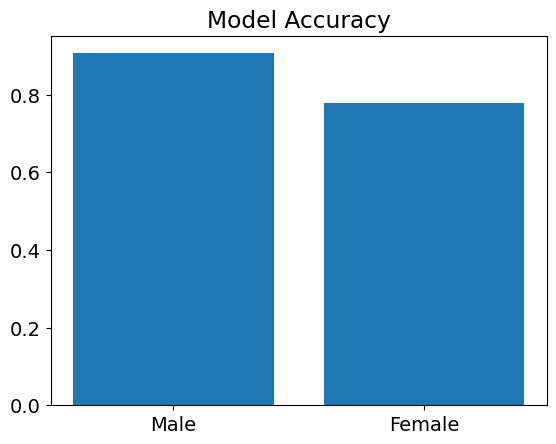

-------------------------------------------


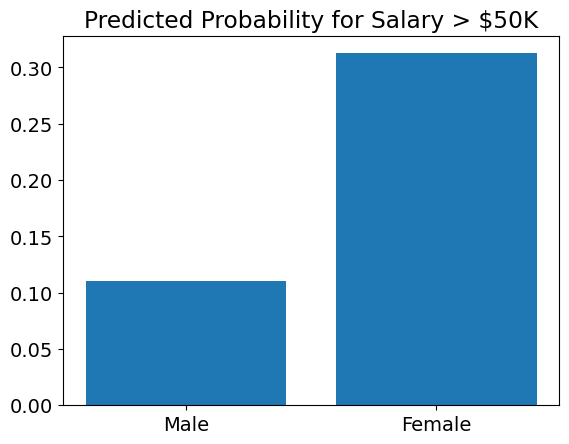

In [18]:
print("Group Metrics: ")
display(dfs['groupMetricsData'])
print("-------------------------------------------")
print("Max Differences: ")
display(dfs['maxDifferencesData'])
print("-------------------------------------------")
print("Bias Metrics : ")
display(dfs['biasMetricsData'])

print("-------------------------------------------")
y_axis =np.array(["Male", "Female"])
x_axis = np.array([(dfs['groupMetricsData']['_acc_'][0]), (dfs['groupMetricsData']['_acc_'][1])])

fig, ax = plt.subplots()
p = ax.bar(x = y_axis, height = x_axis)
ax.set_title('Model Accuracy')
plt.show()

print("-------------------------------------------")
y_axis =np.array(["Male", "Female"])
x_axis = np.array([(dfs['groupMetricsData']['PREDICTED_EVENT'][0]), (dfs['groupMetricsData']['PREDICTED_EVENT'][1])])

fig, ax = plt.subplots()
p = ax.bar(x = y_axis, height = x_axis)
ax.set_title('Predicted Probability for Salary > $50K')
plt.show()

Our model card is built using a few files new to sasctl and requires that data reside in CAS for SAS Information Catalog, which this new function will handle.

In [ ]:
# Step 12: Generate Model Card Function 
train_predict = model_object.predict(x_train)

pzmm.JSONFiles.generate_model_card(
    model_prefix = model_prefix,
    model_files = output_path,
    algorithm = algorithm,
    train_data = x_train_full[original_columns], # changed to x_train_full with original variables (non-OHE'd)
    train_predictions = train_scored[ti],
    target_type='classification',
    target_value=1,
    class_vars=cat_columns, 
    interval_vars=interval_columns
)

To document the requirements for our score code, lets create a requirements file. Since scikit-learn is installed as scikit-learn but imported as sklearn, we're going to tweak the requirements file to make sure we are referencing scikit-learn correctly. 

In [22]:
# Step 13: Generate requirements files
requirements_json = pzmm.JSONFiles.create_requirements_json(output_path)

import json
print(json.dumps(requirements_json, sort_keys=True, indent=4))

for requirement in requirements_json:
    if 'sklearn' in requirement['step']:
        requirement['command'] = requirement["command"].replace('sklearn', 'scikit-learn')
        requirement['step'] = requirement['step'].replace('sklearn', 'scikit-learn')

print(json.dumps(requirements_json, sort_keys=True, indent=4))

with open(Path(output_path) / "requirements.json", "w") as req_file:
    req_file.write(json.dumps(requirements_json, indent=4))

[
    {
        "command": "pip install numpy==1.24.3",
        "step": "install numpy"
    },
    {
        "command": "pip install pandas==2.1.4",
        "step": "install pandas"
    },
    {
        "command": "pip install sklearn==1.3.2",
        "step": "install sklearn"
    }
]
[
    {
        "command": "pip install numpy==1.24.3",
        "step": "install numpy"
    },
    {
        "command": "pip install pandas==2.1.4",
        "step": "install pandas"
    },
    {
        "command": "pip install scikit-learn==1.3.2",
        "step": "install scikit-learn"
    }
]


Alright, we should have all our files now, so let's import our model and its files into SAS Model Manager! With the following function, we can automatically generate the score code and import the model into SAS Model Manager in one step.

In [ ]:
# Step 14: Automatically generate score code and import model 
pzmm.ImportModel.import_model(
        model_files=output_path, # Where are the model files?
        model_prefix=model_prefix, # What is the model name?
        project=mm_project, # What is the project name?
        input_data=x_train_full[['Age', 'WorkClass', 'Education', 'MartialStatus', 
       'Relationship', 'Race', 'Sex', 'HoursPerWeek']], # What does example input data look like?
        predict_method=[dtc.predict_proba, [int, int]], # What is the predict method and what does it return?
        score_metrics=["EM_CLASSIFICATION", "EM_EVENTPROBABILITY"], # What are the output variables?
        overwrite_model=True, # Overwrite the model if it already exists?
        target_values=["0", "1"], # What are the expected values of the target variable?
        target_index=1, # What is the index of the target value in target_values?
        model_file_name=model_prefix + ".pickle", # How was the model file serialized?
        missing_values=False, # Does the data include missing values?
        preprocess_function=preprocess_function # What do we want to do to the data before we score it?
    )
    # Reinitialize the score_code variable when writing more than one model's score code
pzmm.ScoreCode.score_code = ""

And now your model is available in SAS Model Manager where you can run the scoring test, update the model usage properties, add Key Performance Indicators (KPIs) thresholds, and run performance monitoring against the model. Managing the rest of the model lifecycle in SAS Model Manager will complete the rest of the model card.

***
## Conclusion
Now you should have the tools you need to create a model card for Python classification and prediction models! 
***